In [1]:
import numpy as np
import os
import sys

import matplotlib
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
rc('xtick', labelsize=12) 
rc('ytick', labelsize=12)

import emcee

sys.path.append('../../../gwtc3-spin-studies/code/emceeCode/')
import posterior_helper_functions as ph
import postprocessing as pp

sys.path.append('../../../gwtc3-spin-studies/figures/')
import makeCorner as corner

## Trial 1

1. Draw true distribution = half gaussian centered at 0
2. Draw measured value gaussian distributed from true value
3. Gaussian uncertainty centered at measured value

Draw true values

In [2]:
mu_true=0
sigma_true=0.2

true_values_tmp = np.random.normal(loc=mu_true, scale=sigma_true, size=1000)
true_values = np.random.choice(true_values_tmp[np.where((true_values_tmp>=0) & (true_values_tmp<=1))], size=100)

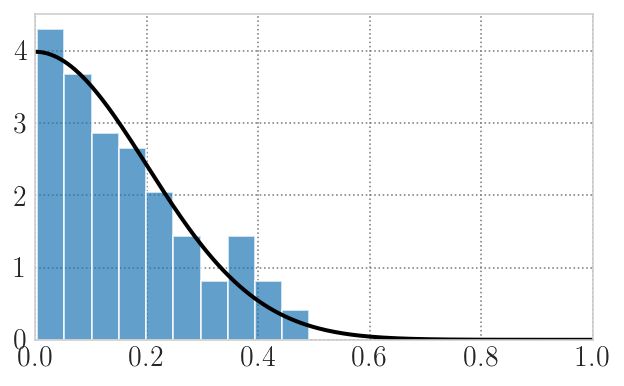

In [3]:
xgrid = np.linspace(0,1,200)

plt.figure(figsize=(5,3))
plt.hist(true_values, density=True, alpha=0.7)
plt.plot(xgrid, ph.calculate_Gaussian_1D(xgrid, mu_true, sigma_true, 0, 1), color='k', lw=2)
plt.xlim(0,1)
plt.show()

Go from true values to measured values

In [11]:
sigma_meas=0.1 # measurement error (small)
measured_values = np.random.normal(loc=true_values, scale=sigma_meas)

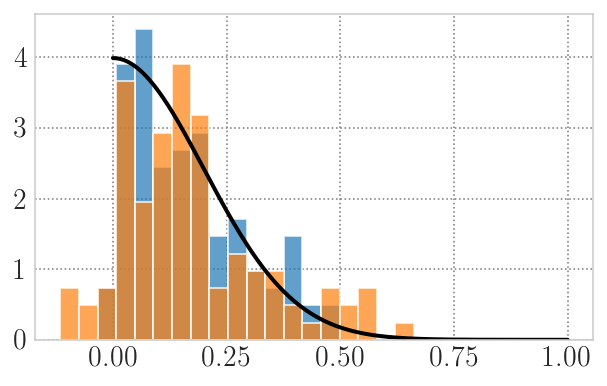

In [12]:
plt.figure(figsize=(5,3))
plt.hist(true_values, density=True, bins=np.linspace(min(measured_values), max(measured_values), 20), alpha=0.7)
plt.hist(measured_values, density=True, bins=np.linspace(min(measured_values), max(measured_values), 20), alpha=0.7)
plt.plot(xgrid, ph.calculate_Gaussian_1D(xgrid, mu_true, sigma_true, 0, 1), color='k', lw=2)
#plt.xlim(0,1)
plt.show()

Give each value a posterior centered at the measured value with std. dev. as above

In [13]:
sampleDict = {}

for i, val in enumerate(measured_values): 
    
    posterior_samps_tmp = np.random.normal(loc=val, scale=sigma_meas, size=20000)
    posterior_samps = np.random.choice(posterior_samps_tmp[np.where((posterior_samps_tmp>=0) & (posterior_samps_tmp<=1))], size=5000)
    
    sampleDict[str(i)] = posterior_samps

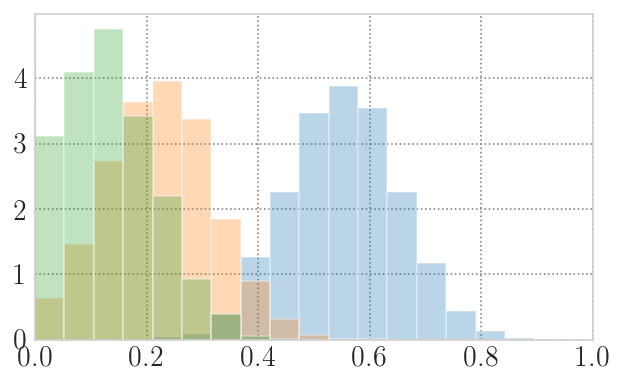

In [18]:
plt.figure(figsize=(5,3))
plt.hist(sampleDict[str(np.argmax(true_values))], density=True, alpha=0.3, bins=np.linspace(0,1,20))
plt.hist(sampleDict[str(np.random.choice(len(true_values)))], density=True, alpha=0.3, bins=np.linspace(0,1,20))
plt.hist(sampleDict[str(np.argmin(true_values))], density=True, alpha=0.3, bins=np.linspace(0,1,20))
plt.xlim(0,1)
plt.show()

Write posterior function for sampler

In [19]:
def log_posterior(c,sampleDict): 
    
    # Unpack hyper-parameters
    mu_chi = c[0]
    sigma_chi = c[1]
    
    # Uniform prior
    if mu_chi < 0 or mu_chi > 1:
        return -np.inf
    elif sigma_chi < 0.05 or sigma_chi > 2:
        return -np.inf
    
    else: 
        # Initialize log-posterior
        logP = 0.
        nSamples = len(sampleDict)
        
        # Loop across "events"
        for event in sampleDict:

            # Unpack posterior samples for this event
            samples = sampleDict[event]
            
            # Evaluate model at the locations of samples for this event
            prob = ph.calculate_Gaussian_1D(samples, mu_chi, sigma_chi, 0, 1)
            
            # Sum over probabilities to get the marginalized likelihood for this event
            pEvidence = (1.0/nSamples)*np.sum(prob)

            # Add to our running total
            logP += np.log(pEvidence)
                
    return logP

Run sampler

In [22]:
# Dimension of hyperparameter space + number of walks + number of steps
dim = 2
nWalkers = 10 
nSteps = 1000

# Initialize walkers
initial_mu_chis = ph.draw_initial_walkers_uniform(nWalkers, (0,1))
initial_sigma_chis = ph.draw_initial_walkers_uniform(nWalkers, (0.05,2))
initial_walkers = np.transpose([initial_mu_chis, initial_sigma_chis])

# Make sampler object
try:
    sampler.reset() # reset if necessary
except: 
    print()
sampler = emcee.EnsembleSampler(
    nWalkers,
    dim,
    log_posterior,
    args=[sampleDict],
    threads=16
)

In [23]:
# Run sampler and print progress as it goes
for i,result in enumerate(sampler.sample(initial_walkers,iterations=nSteps)):
    if i%10==0:
        print(f'On step {i} of {nSteps}', end='\r')

In [24]:
# Get chain
chainRaw = sampler.chain

# Process
chainProcessed = pp.processEmceeChain(chainRaw)

Shape of sample chain:
(10, 1000, 2)
Shape of burned chain:
(10, 750, 2)
Max correlation length across parameters:
16.914766941468912
Shape of downsampled chain:
(10, 47, 2)
Shape of downsampled chain post-flattening:
(470, 2)


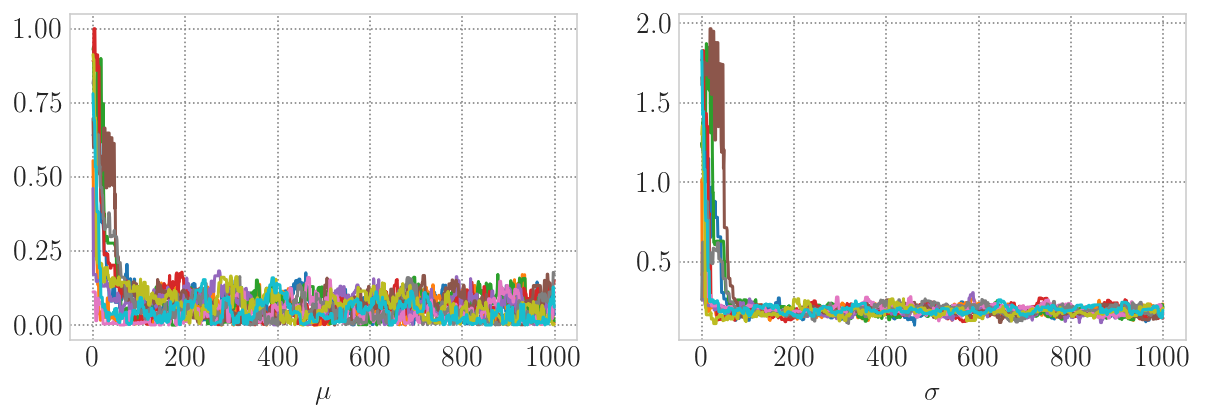

In [25]:
# Plot raw chains

plt.figure(figsize=(10,3))

plt.subplot(121)
plt.plot(np.arange(nSteps), chainRaw[:,:,0].T)
plt.xlabel(r'$\mu$', fontsize=14)

plt.subplot(122)
plt.plot(np.arange(nSteps), chainRaw[:,:,1].T)
plt.xlabel(r'$\sigma$', fontsize=14)

plt.show()

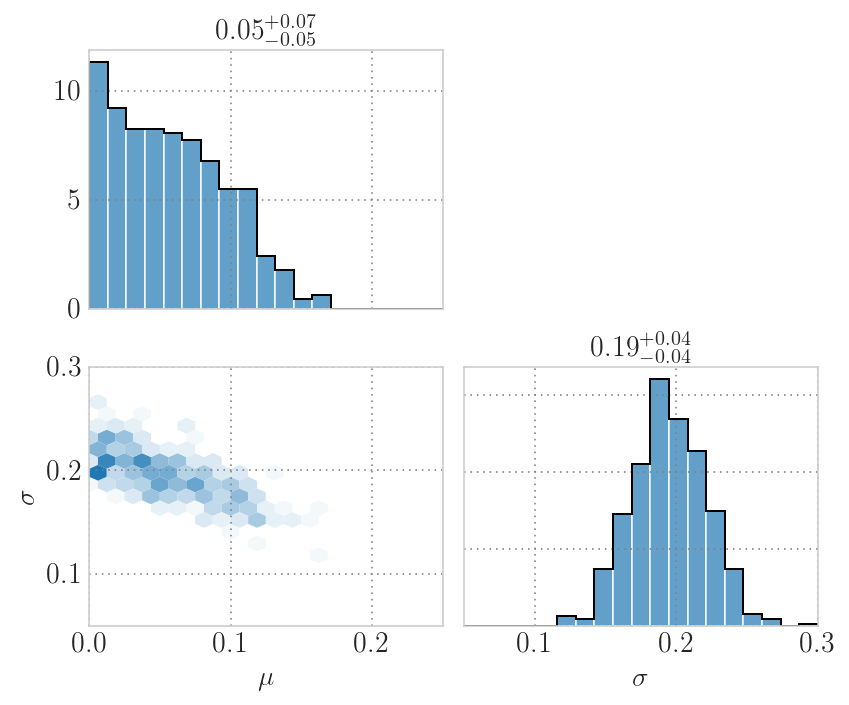

In [26]:
# Cornerplot of processed chains

fig = plt.figure(figsize=(6,5))

toPlot = {
    "mu_chi":{"data":chainProcessed[:,0], "plot_bounds":(0,0.25), "label":r"$\mu$"},
    "sigma_chi":{"data":chainProcessed[:,1], "plot_bounds":(0.05,.3), "label":r"$\sigma$" },
}

corner.plot_corner(fig,toPlot,'#1f78b4',labelsize=14)
plt.tight_layout()
plt.show()

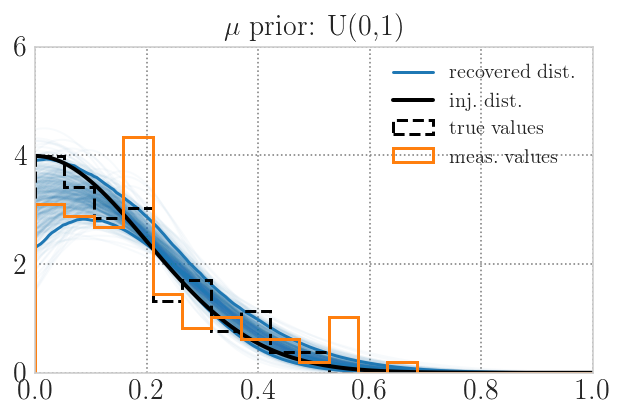

In [27]:
# Trace plot 

plt.figure(figsize=(5,3))

traces = np.zeros((len(xgrid), chainProcessed.shape[0]))
for i,samp in enumerate(chainProcessed): 
    mu,sigma=samp
    traces[:,i] = ph.calculate_Gaussian_1D(xgrid, mu, sigma, 0, 1)
    
plt.plot(xgrid, traces, color='#1f78b4', alpha=0.03, lw=1)
plt.plot(xgrid, np.quantile(traces, 0.05, axis=1), color='#1f78b4', lw=1.5)
plt.plot(xgrid, np.quantile(traces, 0.95, axis=1), color='#1f78b4', lw=1.5, label='recovered dist.')
plt.plot(xgrid, ph.calculate_Gaussian_1D(xgrid, mu_true, sigma_true, 0, 1), color='k', lw=2, label=r'inj.~dist.')

plt.hist(true_values, density=True, bins=np.linspace(0,1,20), histtype='step', lw=1.5, color='k', ls='--', label='true values')
plt.hist(measured_values, density=True, bins=np.linspace(0,1,20), histtype='step', lw=1.5, color='C1', label=r'meas.~values')

plt.title(r'$\mu$ prior: U(0,1)', fontsize=14)
plt.legend(fontsize=10)
    
plt.xlim(0,1)
plt.ylim(0,6)
plt.show()

## Trial 2

Same as trial 1 but with bigger gaussian uncertainty on each posterior

In [28]:
sigma_meas2=0.5 
measured_values2 = np.random.normal(loc=true_values, scale=sigma_meas2)

sampleDict2 = {}

for i, val in enumerate(measured_values2): 
    
    posterior_samps_tmp = np.random.normal(loc=val, scale=sigma_meas2, size=20000)
    posterior_samps = np.random.choice(posterior_samps_tmp[np.where((posterior_samps_tmp>=0) & (posterior_samps_tmp<=1))], size=5000)
    
    sampleDict2[str(i)] = posterior_samps

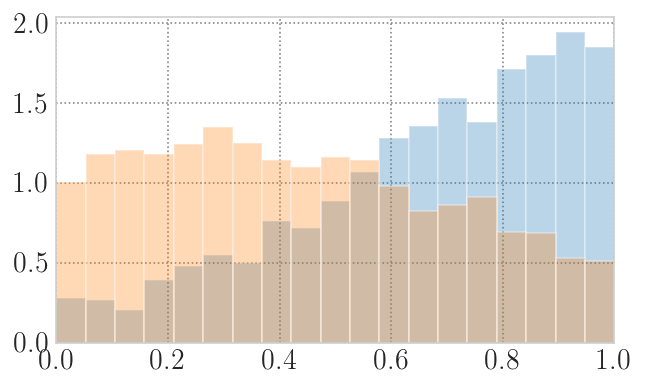

In [29]:
plt.figure(figsize=(5,3))
plt.hist(sampleDict2[str(np.argmax(true_values))], density=True, alpha=0.3, bins=np.linspace(0,1,20))
plt.hist(sampleDict2[str(np.argmin(true_values))], density=True, alpha=0.3, bins=np.linspace(0,1,20))
plt.xlim(0,1)
plt.show()

In [30]:
# Initialize walkers
initial_mu_chis2 = ph.draw_initial_walkers_uniform(nWalkers, (0,1))
initial_sigma_chis2 = ph.draw_initial_walkers_uniform(nWalkers, (0.05,2))
initial_walkers2 = np.transpose([initial_mu_chis2, initial_sigma_chis2])

# Make sampler object
try:
    sampler2.reset() # reset if necessary
except: 
    print()
sampler2 = emcee.EnsembleSampler(
    nWalkers,
    dim,
    log_posterior,
    args=[sampleDict2],
    threads=16
)

In [31]:
# Run sampler and print progress as it goes
for i,result in enumerate(sampler2.sample(initial_walkers2,iterations=nSteps)):
    if i%10==0:
        print(f'On step {i} of {nSteps}', end='\r')

In [32]:
# Get chain
chainRaw2 = sampler2.chain

# Process
chainProcessed2 = pp.processEmceeChain(chainRaw2)

Shape of sample chain:
(10, 1000, 2)
Shape of burned chain:
(10, 750, 2)
Max correlation length across parameters:
20.738763456697505
Shape of downsampled chain:
(10, 38, 2)
Shape of downsampled chain post-flattening:
(380, 2)


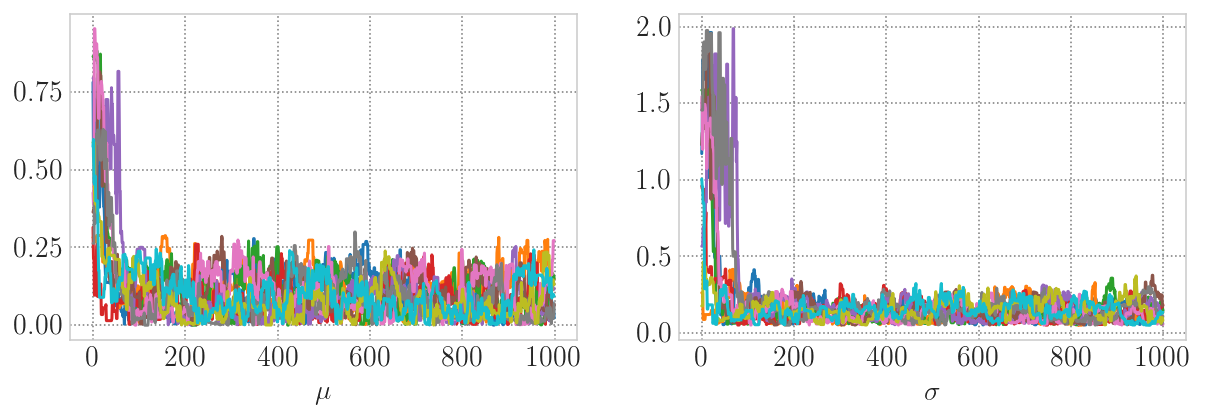

In [33]:
# Plot raw chains

plt.figure(figsize=(10,3))

plt.subplot(121)
plt.plot(np.arange(nSteps), chainRaw2[:,:,0].T)
plt.xlabel(r'$\mu$', fontsize=14)

plt.subplot(122)
plt.plot(np.arange(nSteps), chainRaw2[:,:,1].T)
plt.xlabel(r'$\sigma$', fontsize=14)

plt.show()

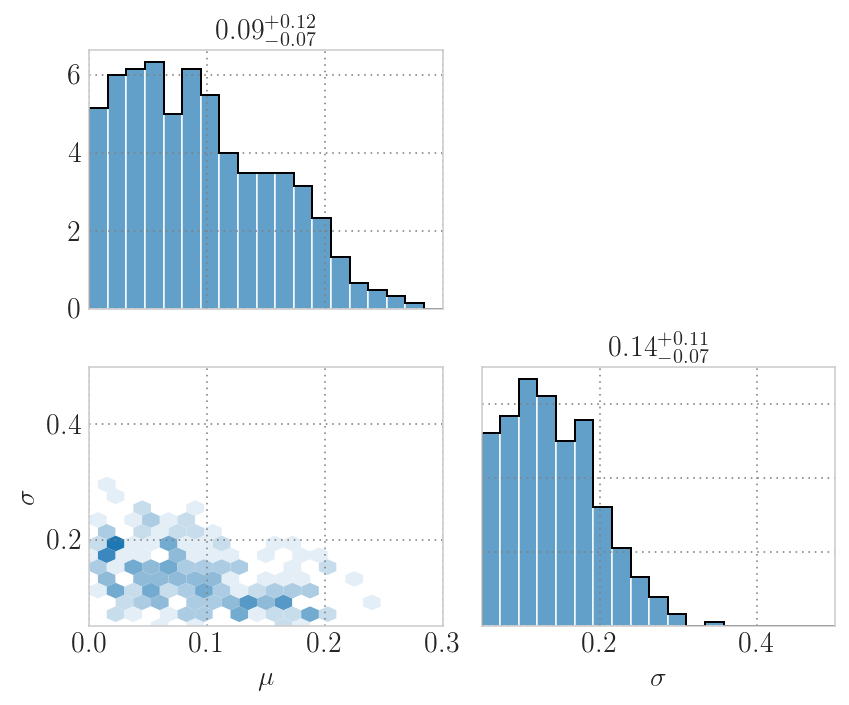

In [45]:
# Cornerplot of processed chains

fig = plt.figure(figsize=(6,5))

toPlot = {
    "mu_chi":{"data":chainProcessed2[:,0], "plot_bounds":(0,0.3), "label":r"$\mu$"},
    "sigma_chi":{"data":chainProcessed2[:,1], "plot_bounds":(0.05,0.5), "label":r"$\sigma$" },
}

corner.plot_corner(fig,toPlot,'#1f78b4',labelsize=14)
plt.tight_layout()
plt.show()

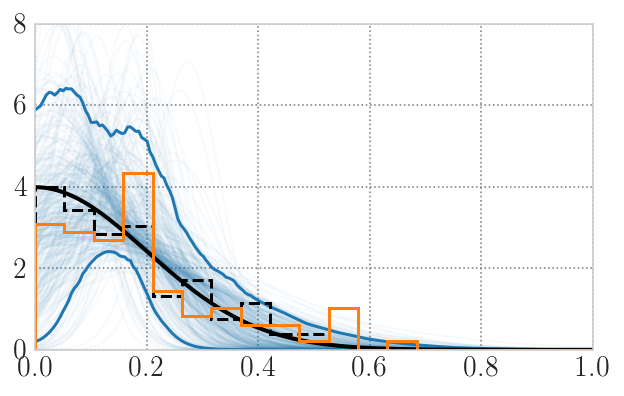

In [44]:
# Trace plot 

plt.figure(figsize=(5,3))

traces2 = np.zeros((len(xgrid), chainProcessed2.shape[0]))
for i,samp in enumerate(chainProcessed2): 
    mu,sigma=samp
    traces2[:,i] = ph.calculate_Gaussian_1D(xgrid, mu, sigma, 0, 1)
    
plt.plot(xgrid, traces2, color='#1f78b4', alpha=0.03, lw=1)
plt.plot(xgrid, np.quantile(traces2, 0.05, axis=1), color='#1f78b4', lw=1.5)
plt.plot(xgrid, np.quantile(traces2, 0.95, axis=1), color='#1f78b4', lw=1.5)
plt.plot(xgrid, ph.calculate_Gaussian_1D(xgrid, mu_true, sigma_true, 0, 1), color='k', lw=2)

plt.hist(true_values, density=True, bins=np.linspace(0,1,20), histtype='step', lw=1.5, color='k', ls='--')
plt.hist(measured_values, density=True, bins=np.linspace(0,1,20), histtype='step', lw=1.5, color='C1')
    
plt.xlim(0,1)
plt.ylim(0,8)
plt.show()

## Trial 3

Same as trial 1 but allowing $\mu$ to go down to -1

In [36]:
def log_posterior2(c,sampleDict): 
    
    # Unpack hyper-parameters
    mu_chi = c[0]
    sigma_chi = c[1]
    
    # Uniform prior
    if mu_chi < -1 or mu_chi > 1:
        return -np.inf
    elif sigma_chi < 0.05 or sigma_chi > 2:
        return -np.inf
    
    else: 
        # Initialize log-posterior
        logP = 0.
        nSamples = len(sampleDict)
        
        # Loop across "events"
        for event in sampleDict:

            # Unpack posterior samples for this event
            samples = sampleDict[event]
            
            # Evaluate model at the locations of samples for this event
            prob = ph.calculate_Gaussian_1D(samples, mu_chi, sigma_chi, 0, 1)
            
            # Sum over probabilities to get the marginalized likelihood for this event
            pEvidence = (1.0/nSamples)*np.sum(prob)

            # Add to our running total
            logP += np.log(pEvidence)
                
    return logP

In [37]:
# Initialize walkers
initial_mu_chis3 = ph.draw_initial_walkers_uniform(nWalkers, (-1,1))
initial_sigma_chis3 = ph.draw_initial_walkers_uniform(nWalkers, (0.05,2))
initial_walkers3 = np.transpose([initial_mu_chis3, initial_sigma_chis3])

# Make sampler object
try:
    sampler3.reset() # reset if necessary
except: 
    print()
sampler3 = emcee.EnsembleSampler(
    nWalkers,
    dim,
    log_posterior2,
    args=[sampleDict],
    threads=16
)

# Run sampler and print progress as it goes
for i,result in enumerate(sampler3.sample(initial_walkers3,iterations=nSteps)):
    if i%10==0:
        print(f'On step {i} of {nSteps}', end='\r')
        
        
# Get chain
chainRaw3 = sampler3.chain

# Process
chainProcessed3 = pp.processEmceeChain(chainRaw3)


Shape of sample chain:
(10, 1000, 2)
Shape of burned chain:
(10, 750, 2)
Max correlation length across parameters:
19.288282082009836
Shape of downsampled chain:
(10, 40, 2)
Shape of downsampled chain post-flattening:
(400, 2)


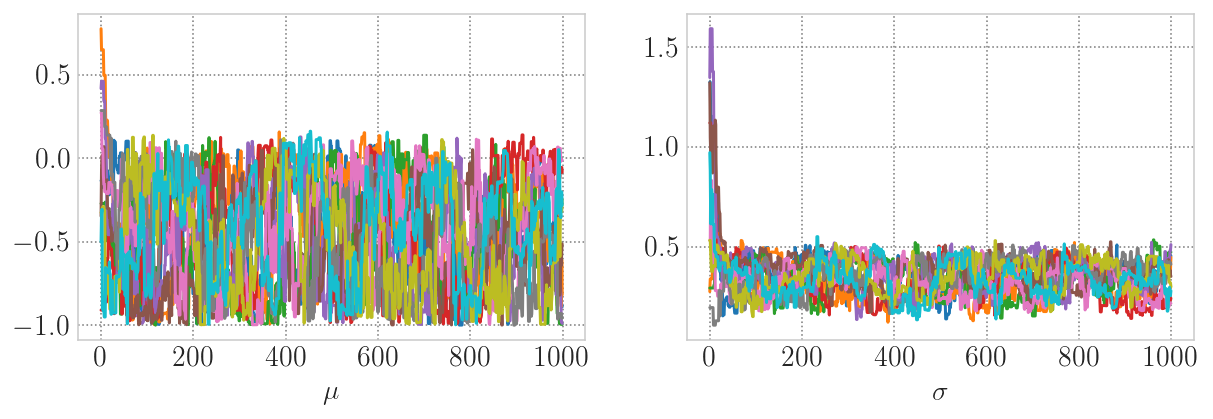

In [38]:
# Plot raw chains

plt.figure(figsize=(10,3))

plt.subplot(121)
plt.plot(np.arange(nSteps), chainRaw3[:,:,0].T)
plt.xlabel(r'$\mu$', fontsize=14)

plt.subplot(122)
plt.plot(np.arange(nSteps), chainRaw3[:,:,1].T)
plt.xlabel(r'$\sigma$', fontsize=14)

plt.show()

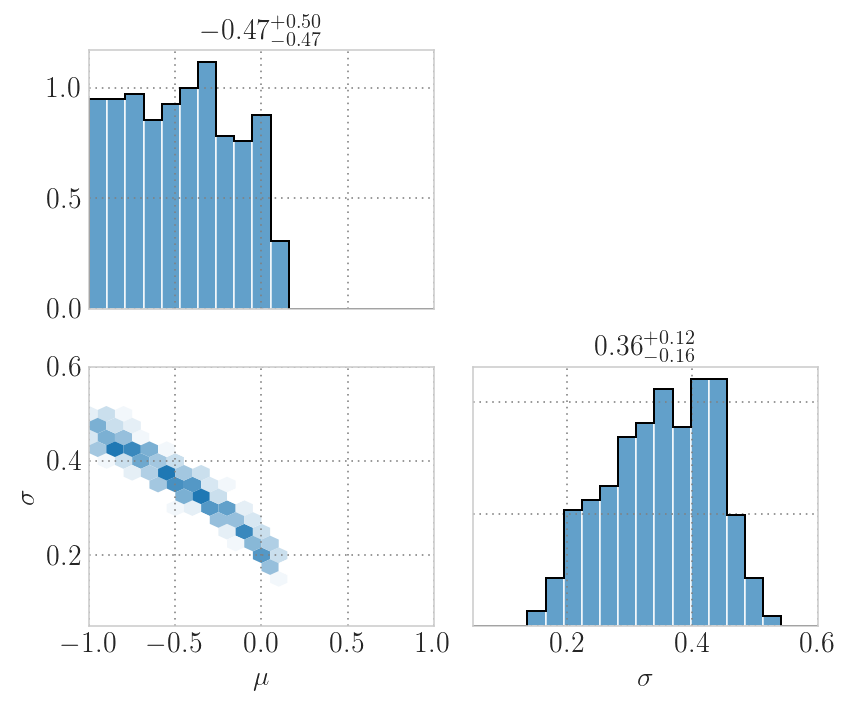

In [43]:
# Cornerplot of processed chains

fig = plt.figure(figsize=(6,5))

toPlot = {
    "mu_chi":{"data":chainProcessed3[:,0], "plot_bounds":(-1,1), "label":r"$\mu$"},
    "sigma_chi":{"data":chainProcessed3[:,1], "plot_bounds":(0.05,0.6), "label":r"$\sigma$" },
}

corner.plot_corner(fig,toPlot,'#1f78b4',labelsize=14)
plt.tight_layout()
plt.show()

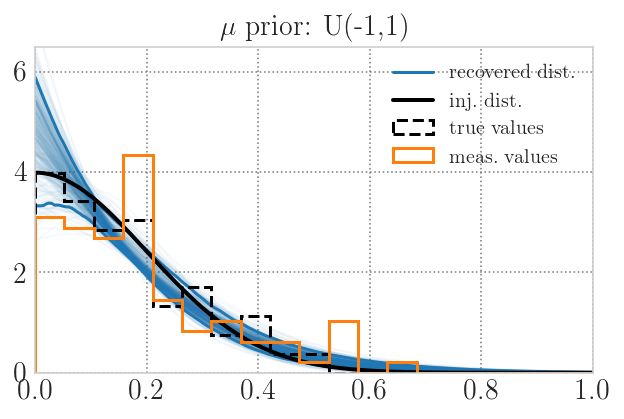

In [42]:
# Trace plot 

plt.figure(figsize=(5,3))

traces3 = np.zeros((len(xgrid), chainProcessed3.shape[0]))
for i,samp in enumerate(chainProcessed3): 
    mu,sigma=samp
    traces3[:,i] = ph.calculate_Gaussian_1D(xgrid, mu, sigma, 0, 1)
    
plt.plot(xgrid, traces3, color='#1f78b4', alpha=0.03, lw=1)
plt.plot(xgrid, np.quantile(traces3, 0.05, axis=1), color='#1f78b4', lw=1.5)
plt.plot(xgrid, np.quantile(traces3, 0.95, axis=1), color='#1f78b4', lw=1.5, label='recovered dist.')
plt.plot(xgrid, ph.calculate_Gaussian_1D(xgrid, mu_true, sigma_true, 0, 1), color='k', lw=2, label=r'inj.~dist.')

plt.hist(true_values, density=True, bins=np.linspace(0,1,20), histtype='step', lw=1.5, color='k', ls='--', label='true values')
plt.hist(measured_values, density=True, bins=np.linspace(0,1,20), histtype='step', lw=1.5, color='C1', label=r'meas.~values')

plt.title(r'$\mu$ prior: U(-1,1)', fontsize=14)
plt.legend(fontsize=10)

plt.xlim(0,1)
plt.ylim(0,6.5)
plt.show()